# Le dilemme itéré du prisonnier

Auteur : Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Louisa Fodil (CRISTAL/SMAC), Céline Petitpré (CRISTAL/SMAC)

Création : 18/01/2018

## Introduction

Le Dilemme du prisonnier (PD) est un jeu **simultané**, **à deux joueurs**, **à somme non nulle**, mis en évidence par Merill Flood & Melvin Dreschler en 1950 pour montrer que l'équilibre de Nash n'est pas toujours idéal. La version itérée du jeu (IPD) permet d'exprimer des stratégies qui se basent sur l'historique de jeu, et donc apprennent du passé. En 1980 Robert Axelrod organise un concours pour la version itérée du jeu dans lequel l'un des participants, Anatol Rappoport met en évidence la célèbre stratégie TFT. Cette version itérée et cette stratégie TFT sont populariséees en 1984 dans le livre de Robert Axelrod "The Evolution of Cooperation". Depuis, des milliers de publications ont été réalisées sur ce sujet, dans tous les domaines !

Ce notebook a pour objectif de montrer comment établir et comparer des stratégies à ce jeu.

On considère ici une classe `Game` permettant de coder un jeu

### Game(tab, actions)
<ul>
<li> tab : la liste des couples de scores
<li> actions : la liste des stratégies possibles
<ul>

#### Methodes
<ul>
<li> getDominantStrategies(self, strict='True') qui imprime une liste d'indices des stratégies non dominées et qui renvoie un nouveau Game avec cette nouvelle matrice
<li> getNash(self) qui renvoie une liste d'indices des équilibres de Nash
<li> getPareto(self) qui renvoie une liste d'indices des équilibres de Pareto

<ul>

In [1]:
%run Game.py

dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game(dip,['C','D'])
g.getNash()

[(1, 1)]

# Une stratégie

Une stratégie a pour objectif de décider du coup à jouer. Outre la matrice des gains, les informations disponibles pour une stratégie sont les coups joués par lesd eux joueurs dans le passé. Les stratégies les plus simples sont bien évidemment les stratégies qui ne prennent pas en compte ce passé, comme les stratégies qui jouent périodiquement la même séquence de coups. Pour assurer un principe d'autonomie de chaque agent, une stratégie est bien sur capable de fournir son prochain coup, mais s'occupe elle-même de stocker ses précédents coups si necessaire.

#### Créons une classe de stratégies de ce type
La classe que nous définissons ici est très simple : des stratégies qui jouent périodiquement les coups, sans réfléchir beaucoup ! Pour l'instant, elle n'est liée à aucun jeu puisque ce type de comportement peut se retrouver dans n'importe quel jeu.

In [2]:
from abc import abstractmethod
class Strategy():
    def setMemory(self,mem):
        pass
    
    def getAction(self,tick):
        pass
    
    def __copy__(self):
        pass

    def update(self,x,y):
        pass
    

class Periodic(Strategy):
    def __init__(self, sequence, name=None):
        super().__init__()
        self.sequence = sequence.upper()
        self.step = 0
        self.name = "per_"+sequence if (name == None) else name

    def getAction(self,tick):
        return self.sequence[tick % len(self.sequence)]

    def clone(self):
        object = Periodic(self.sequence, self.name)
        return object

    def update(self,x,y):
        pass

#### Testons notre classe Periodic

In [3]:
s1 = Periodic("abc")
print(s1.name,end="\t")
for i in range (0,10):
    print(s1.getAction(i), end=' ')
# IL DOIT Y AVOIR 10 COUPS. çA COMMENCE PAR A ET çA FINIT PAR A    

per_abc	A B C A B C A B C A 

# Un meeting
Un meeting est une rencontre de deux stratégies durant un certain nombre de coups. Le score de chacune est la somme des scores obtenus lors de chaque coup, conformément à la matrice du jeu.

In [4]:
class Meeting :      
    def __init__(self,game,s1,s2,length=1000):
        self.game = game
        self.s1=s1.clone()
        self.s2=s2.clone()
        self.length=length
        self.nb_cooperation_s1 = 0
        self.nb_cooperation_s2 = 0
        
    def reinit(self):
        self.s1_score=0
        self.s2_score=0
        self.s1_rounds=""
        self.s2_rounds=""
    
    def run(self):
        self.reinit()
        for tick in range(0,self.length):
            c1=self.s1.getAction(tick).upper()
            c2=self.s2.getAction(tick).upper()
            if (c1 == "C"):
                self.nb_cooperation_s1 +=1
            if (c2 == "C"):
                self.nb_cooperation_s2 +=1
            self.s1_rounds+=c1
            self.s2_rounds+=c2
            self.s1.update(c1,c2)
            self.s2.update(c2,c1)
            act=self.game.actions
            self.s1_score+=self.game.scores['x'][act.index(c1),act.index(c2)]
            self.s2_score+=self.game.scores['y'][act.index(c1),act.index(c2)]

Une rencontre entre deux stratégies est triviale : on initialise un jeu, on crée 2 stratégies, et on les passe au Meeting.

In [5]:
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game(dip,['C','D'])
s1=Periodic("CCD")
s2=Periodic("DDC")
m = Meeting(g,s1,s2,10)
m.run()
print(m.s1.name+"\t"+m.s1_rounds+" "+str(m.s1_score))
print(m.s2.name+"\t"+m.s2_rounds+" "+str(m.s2_score))
# ON DOIT AVOIR 15,35
print("Le nombre de coopérations : " )
print (m.s1.name+"\t" + str(m.nb_cooperation_s1))
print (m.s2.name+"\t" + str(m.nb_cooperation_s2))

per_CCD	CCDCCDCCDC 15
per_DDC	DDCDDCDDCD 35
Le nombre de coopérations : 
per_CCD	7
per_DDC	3


# Un tournoi

Un tournoi s'applique à un ensemble de stratégies. Il consiste à faire se rencontrer tout couple de stratégies dans un meeting, y compris chaque stratégie contre elle-même. On appelle ce type de tournoi un "round-robin". On remplit ainsi une matrice carrée de scores. Dans un tel tournoi, le score de chaque stratégie est la somme des scores qu'elle a obtenue. La stratégie gagnante est celle qui obtient le score le plus grand.

Un tournoi est maintenant défini à l'aide de 4 paramètres : le jeu sur lequel il s'applique, l'ensemble des stratégies évaluées, la longueur des parties, le nombre de répétitions effectuées


In [6]:
import pandas as pd
import numpy as np

class Tournament:
    def __init__(self, game, strategies, length=1000, repeat=1):
        self.strategies = strategies
        self.game = game
        self.length=length
        self.repeat=repeat
        size=len(strategies);
        df = pd.DataFrame(np.zeros((size,size+1),dtype=np.int32))
        df.columns, df.index = [s.name for s in self.strategies]+["Total"], [s.name for s in self.strategies]
        self.matrix = df
        df2 = pd.DataFrame(np.zeros((size,size+1),dtype=np.int32))
        df2.columns, df2.index = [s.name for s in self.strategies]+["Total"], [s.name for s in self.strategies]
        self.cooperations = df2

    def run(self):
        for k in range(self.repeat):
            for i in range (0,len(self.strategies)):
                for j in range (i,len(self.strategies)):
                    meet = Meeting(self.game, self.strategies[i], self.strategies[j], self.length)
                    meet.run()
                    self.matrix.at[self.strategies[i].name, self.strategies[j].name] = meet.s1_score
                    self.matrix.at[self.strategies[j].name, self.strategies[i].name] = meet.s2_score
                    self.cooperations.at[self.strategies[i].name, self.strategies[j].name] = meet.nb_cooperation_s1
                    self.cooperations.at[self.strategies[j].name, self.strategies[i].name] = meet.nb_cooperation_s2
        self.matrix["Total"] = self.matrix.sum(axis=1)
        self.matrix.sort_values(by='Total', ascending=False, inplace=True)
        rows = list(self.matrix.index) + ["Total"]
        self.matrix = self.matrix.reindex(columns=rows)
        self.cooperations["Total"] = self.cooperations.sum(axis=1)
        self.cooperations.sort_values(by='Total', ascending=False, inplace=True)
        rows = list(self.cooperations.index) + ["Total"]
        self.cooperations = self.cooperations.reindex(columns=rows)

#### Faisons un tournoi
Le Dilemme des prisonniers est un jeu **à somme non nulle** : on ne gagne pas la même chose dans toutes les situations. Il est important de noter que dans le tournoi on ne compte pas le nombre de victoire mais le cumul des scores !

In [7]:
bag = []
bag.append(Periodic('C'))
bag.append(Periodic('D'))
bag.append(Periodic('DDC'))
bag.append(Periodic('CCD'))
t=Tournament(g,bag,10)
t.run()
print("La matrice de scores : ")
print(t.matrix)
# SUR 10 COUPS : [('per_D', 120), ('per_DDC', 102), ('per_CCD', 78), ('per_C', 60)]
print("La matrice de coopérations : ")
print(t.cooperations)

La matrice de scores : 
         per_D  per_DDC  per_CCD  per_C  Total
per_D       10       22       38     50    120
per_DDC      7       16       35     44    102
per_CCD      3       15       24     36     78
per_C        0        9       21     30     60
La matrice de coopérations : 
         per_C  per_CCD  per_DDC  per_D  Total
per_C       10       10       10     10     40
per_CCD      7        7        7      7     28
per_DDC      3        3        3      3     12
per_D        0        0        0      0      0


## Générer des ensembles de stratégies

Constituer une "soupe" de stratégies pour tester la performance d'une stratégie donnée peut être considéré comme subjectif. L'idéal est de constituer des soupes indiscutables, par exemple en constituant des ensembles de toutes les stratégies répondant à une contrainte globale.
Nous pouvons par exemple constituer l'ensemble de toutes les périodiques de période 1 (il y en a 2) et/ou de période 2 (il y en a $2^2=4$) et/ou de période 3 (il y en a $2^3=8$), voir toutes ensembles.
(on notera que l'on génère CCC qui correspond bien évidemment à CC ou C)


In [8]:
import itertools
cards = ['C','D']
periodics = [p for p in itertools.product(cards, repeat=1)]+[p for p in itertools.product(cards, repeat=2)] + [p for p in itertools.product(cards, repeat=3)]
strats = [Periodic(''.join(p)) for p in periodics] # join to transform in strings
print(str(len(strats))+" stratégies générées")
# 14 SONT GENEREES : 2 à un coup, 4 à deux coups, 8 à trois coups

14 stratégies générées


# Les compétitions écologiques

Les tournois donnent un classement interessant, mais insuffisant. Ils n'étudient pas la robustesse d'une stratégie selon le nombre de représentants des adversaires. La compétition écologique répond à ce problème : elle permet de faire varier les populations de chaque stratégie. Le principe d'une compétition écologique est très simple. Initialement, on considère `n` représentants de chacune des `s` stratégies évaluées. Les `n*s` agents jouent tous les uns contre les autres dans un tournoi. à l'étape 1, les repésentants de chaque stratégie sont obtenus proportionnellement à leur réussite à l'étape précédente. Meilleur vous-êtes, plus vous aurez de descendants. Une compétition écologique oblige donc une stratégie à être robuste aux changement de nombre d'adversaires. Un classement écologique est donc plus "robuste" qu'un classement de tournoi. On compend immédiatement que pour être bien classé, il est préférable de très bien jouer contre ses propres congénères, puisqu'ils seront de plus en plus nombreux.
Une compétition écologique peut alors se représenter sur un graphique temporel, les générations en abscisse et les populations de chaque stratégie en ordonnée. On utilisera *matplotlib* pour calculer ces graphiques.

In [9]:
import pandas
import copy
import math
import matplotlib.pyplot as plt
%matplotlib inline

class Ecological:
    def __init__(self, game, strategies, length=1000, repeat=1, pop=100):
        self.strategies = strategies
        self.pop = pop
        self.game = game
        self.generation = 0 #Numéro de la génération actuelle
        self.base = pop*len(strategies)
        self.historic = pandas.DataFrame(columns = [strat.name for strat in strategies])
        self.historic.loc[0] = [pop for x in range (len(strategies))]
        self.extinctions = dict((s.name,math.inf) for s in strategies)
        self.scores = dict((s.name,0) for s in strategies)
        self.tournament = Tournament(self.game, self.strategies,length,repeat)
        self.tournament.run()
        
    def run(self):
        dead = 0
        stab = False
        while ((self.generation < 1000) and (stab==False)):
            parents = list(copy.copy(self.historic.loc[self.generation]))
            for i in range (len(self.strategies)):
                strat=self.strategies[i].name
                if (self.historic.at[self.generation, strat] != 0):
                    score = 0
                    for j in range(len(self.strategies)): 
                        strat2 = self.strategies[j].name
                        if (self.historic.at[self.generation, strat2] != 0):
                            if i==j:
                                score+=(self.historic.at[self.generation, strat]-1)*self.tournament.matrix.at[strat,strat2]
                            else:
                                score+=self.historic.at[self.generation, strat2]*self.tournament.matrix.at[strat,strat2]
                        self.scores[strat] = score
            total = 0
            for strat in self.strategies:
                total+=self.scores[strat.name]*self.historic.at[self.generation, strat.name]
            for strat in self.strategies:
                parent = self.historic.at[self.generation, strat.name]
                if (self.scores[strat.name] != 0):
                    self.historic.at[self.generation+1, strat.name] = math.floor(self.base*parent*self.scores[strat.name]/total)
                elif (self.scores[strat.name] == 0):
                    self.historic.at[self.generation+1, strat.name] = 0
                    dead += 1
                if ((parent!=0) and (self.historic.at[self.generation+1, strat.name] == 0)):
                    self.extinctions[strat.name] = self.generation+1
                elif (self.historic.at[self.generation+1, strat.name] != 0):
                    self.extinctions[strat.name] = self.historic.at[self.generation+1, strat.name]*1000
                if (dead == len(self.strategies) - 1):
                    stab = True
            self.generation+=1
            if (parents == list(self.historic.loc[self.generation])):stab = True
        trie = sorted(self.extinctions.items(), key=lambda t:t[1], reverse=True)
        df_trie = pandas.DataFrame()
        for t in trie :
            df_trie[t[0]]=self.historic[t[0]]
        self.historic = df_trie
        return self.historic

    def saveData(self):
        date = datetime.datetime.now()
        self.historic.to_csv(str(date)+'.csv', sep=';', encoding='utf-8')

    def drawPlot(self,nbCourbes=None,nbLegends=None):
        nbCourbes = len(self.strategies) if (nbCourbes==None) else nbCourbes
        nbLegends = len(self.strategies) if (nbLegends==None) else nbLegends
        strat = self.historic.columns.tolist()
        for i in range(nbCourbes):
            plt.plot(self.historic[strat[i]], label=strat[i] if (i<nbLegends) else '_nolegend_')
        plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Population')
        plt.xlabel('Generation')
        plt.show()
        #date = datetime.datetime.now()
        #plt.savefig(str(date)+'.png', dpi=1000)

#### Faisons une compétition écologique avec les stratégies générées préalablement.
on affiche ici la courbe d'évolution des populations ainsi le dictionnaire de scores

In [ ]:
eco = Ecological(g, strats)
eco.run()
plt.figure(figsize=(10,8))    # pour définir la taille de la figure
eco.drawPlot(None,None)
print(eco.scores)

#### Réaliser une compétition écologique avec gentille (qui joue tout le temps coopérer) et méchante (qui joue tout le temps trahir)
Afficher les scores et la courbe

In [ ]:
gentille = Periodic("C")
mechante = Periodic("D")
eco = Ecological(g, [gentille, mechante], length = 10)
eco.run()
print(eco.scores)
eco.drawPlot()

## Des stratégies réactives

In [10]:
class Tft(Strategy):
    def __init__(self):
        super().__init__()
        self.name = "tft"
        self.hisPast=""
        
    def getAction(self,tick):
        return 'C' if (tick==0) else self.hisPast[-1]

    def clone(self):
        return Tft()

    def update(self,my,his):
        self.hisPast+=his
    
    
class Spiteful(Strategy):
    def __init__(self):
        super().__init__()
        self.name = "spiteful"
        self.hisPast=""
        self.myPast=""
        
    def getAction(self,tick):
        if (tick==0):
                return 'C'
        if (self.hisPast[-1]=='D' or self.myPast[-1]=='D') :
            return 'D'
        else :
            return 'C'

    def clone(self):
        return Spiteful()

    def update(self,my,his):
        self.myPast+=my
        self.hisPast+=his




#### Réaliser une compétititon écologique avec gentille, mechante, Tft et Periodic("CCD")
 
Cette expérience illustre clairement les phénomènes de type proies/prédateurs qui se produisent. per_D gagne le tournoi, elle augmente donc en population. Mais son gain se fait principalement au détriment de per_C. Si ce dernier périclite, alors per_D périclite aussi faute de stratégie à exploiter. En résulte une magnifique inversion de tendance. Gagner un tournoi, n'est pas gagner une compétition écologique.

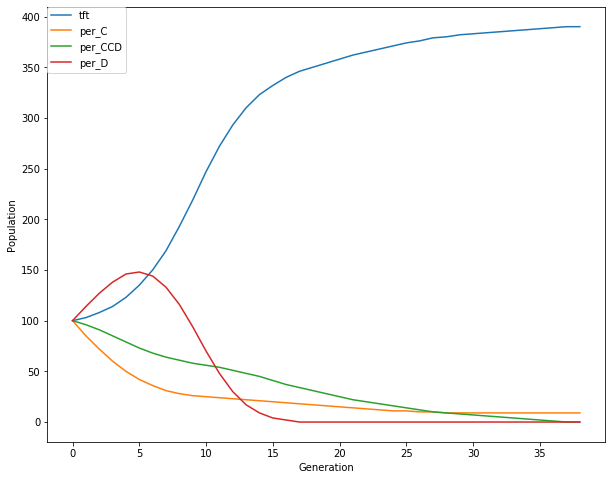

In [11]:
eco = Ecological(g, [Periodic('C'),Periodic('D'),Periodic('CCD'),Tft()])
eco.run()
plt.figure(figsize=(10,8))    # pour définir la taille de la figure
eco.drawPlot()
# DANS CETTE EXPERIENCE, ALL_D GAGNE LE TOURNOI, MAIS C'EST TFT QUI GAGNE LA COMPETITION ECOLOGIQUE

In [ ]:
# Accès aux données des DataFrame

# Attention ! avec un dataframe df
# chaque colonne nommée peut etre utilisée comme attribut
# Si on met un seul crochet, c'est une colonne
# donc tournoi.Total et tournoi['Total'] c'est pareil
# 
# si on met des crochets directs c'est df[Col][Lig]
# que l'on peut donc aussi écrire df.Col[lig]
# Si on utilise les fonctions loc, iloc et at, c'est df.iloc[lig,col]
# donc tournoi['Total'][1] est équivalent à tournoi.iloc[1,4]
# Par ailleurs, par défaut le dataframe utilise des entiers comme index
# dans iloc, on met des index ... sauf si on utilise la notation a:b auquel cas ce sont des adresses relatives

tournoi=eco.tournament.matrix
#print("--- La matrice complète du tournoi triée")
#print(tournoi) 
#print("--- Les gagnants du tournoi")
#print(tournoi['Total']) 
#print("--- Les 3 premiers gagnants du tournoi")
#print(tournoi['Total'][0:3])
#print("--- Les gagnants qui ont fait plus de 10000")
#print(tournoi['Total'][tournoi['Total']>10000])


evol=eco.historic
#print("--- L'historique complet trié")
#print(evol)
#print("--- Les populations finales classées")
#print(evol.iloc[eco.generation])
#print(evol.iloc[-1])
#print(evol.tail(1))
#print("--- Les 2 premiers de la compétition")
#print(evol.iloc[-1][0:2]) 
#print("--- Les derniers survivants")
#print(evol.iloc[-1][evol.iloc[-1]>0]) 
#print("--- la ligne quand tft=340 ?")
#evol.loc[evol.tft==340]
#print("--- A quel indice per_C et per_D se croisent ?")
#print(evol.loc[evol.per_C > evol.per_D].loc[evol.per_D!=0])
# Ecrire l'équivalent de select * from evol where ...
#evol.loc[(evol.tft>300) & (evol.per_D>0)]
# depuis pandas0.13  ... s'écrit
#evol.query('tft>300 & per_D>0')

#eco.drawPlot()


# La famille Memory

In [13]:
class Mem(Strategy):
    def __init__(self, x, y, genome, name=None):
        self.name = name
        self.x = x
        self.y = y
        self.genome = genome
        if (name == None): #Nom par défaut si l'utilisateur ne le définit pas
            self.name = genome
        self.myMoves = [] #contains my x last moves
        self.itsMoves = [] #contains its y last moves

    def clone(self):
        return Mem(self.x, self.y, self.genome, self.name)

    def getAction(self, tick):
        if (tick < max(self.x, self.y)):
            return self.genome[tick]
        cpt = 0
        for i in range(self.x-1,-1,-1):
            cpt*=2
            if (self.myMoves[i] == 'D'):
                cpt+=1
        for i in range(self.y-1,-1,-1):
            cpt*=2
            if (self.itsMoves[i] == 'D'):
                cpt+=1
        cpt += max(self.x, self.y)
        return self.genome[cpt]

    def update(self, myMove, itsMove):
        if (self.x > 0):
            if(len(self.myMoves) == self.x):
                del self.myMoves[0]
            self.myMoves.append(myMove)
        if (self.y > 0):
            if(len(self.itsMoves) == self.y):
                del self.itsMoves[0]
            self.itsMoves.append(itsMove)
            
            
#Mem(0,0,'C','allc')
#Mem(0,0,'D','alld')
#Mem(1,0,'cDC','percd')
#Mem(1,0,'dDC','perdc')
#Mem(0,1,'cCD','tft')
#Mem(0,1,'dCD','mistrust')
#Mem(1,1,'cCDDD','spiteful')
#Mem(1,1,'cCDDC','pavlov')
#Mem(0,2,'ccCCCD','tf2t')
#Mem(0,2,'ccCDDD','hard_tft')
#Mem(1,2,'ccCCCDCDDD','slow_tft')
#Mem(1,2,'ccCDCDDCDD','winner12') 
#Mem(1,2,'','tft_spiteful')
#Mem(1,2,'ccCDDDDDDD','spiteful_cc')




In [14]:
# Exercice :  Petit test d'équivalence : Faire deux tournois avec Gentille, Mechante, Tft, Spiteful, Periodic('CD') et Periodic('DC').
# Le premier en utilisant Periodic, Tft() et Spiteful()
# Le deuxieme en utilisant seulement des Mem(x,y,"",name)
# Vérifier l'équivalence en imprimant la matrice du tournoi

bag1 = [Periodic('C'),Periodic('D'),Tft(),Spiteful(),Periodic('CD'),Periodic('DC')]
t1=Tournament(g,bag1,100)
t1.run()
print(t1.matrix)

bag2 = [Mem(0,0,'C','allc'),Mem(0,0,'D','alld'),Mem(0,1,'cCD','tft'),
        Mem(1,1,'cCDDD','spiteful'),Mem(1,0,'cDC','percd'),Mem(1,0,'dDC','perdc')]
t2=Tournament(g,bag2,100)
t2.run()
print(t2.matrix)

          spiteful  tft  per_D  per_CD  per_DC  per_C  Total
spiteful       300  300     99     297     299    300   1595
tft            300  300     99     248     250    300   1497
per_D          104  104    100     300     300    500   1408
per_CD          57  253     50     200     250    400   1210
per_DC          54  250     50     250     200    400   1204
per_C          300  300      0     150     150    300   1200
          spiteful  tft  alld  percd  perdc  allc  Total
spiteful       300  300    99    297    299   300   1595
tft            300  300    99    248    250   300   1497
alld           104  104   100    300    300   500   1408
percd           57  253    50    200    250   400   1210
perdc           54  250    50    250    200   400   1204
allc           300  300     0    150    150   300   1200


## Les générer toutes
Pour une famille Mem(x,y), le génome est de taille `max(x,y)`pour l'amorce plus `2^(x+y)` pour toutes les situations s du passé sur `x` coups de l'un et `y` coups de l'autre. Il y a donc `2^(max(x,y)+2^(x+y))` strategies à générer. Pour obtenir tous ces éléments il suffit donc de calculer toutes les instanciations possibles de C et D dans le génome, ce qui se fait, encore une fois , avec un produit cartésien.

| famille  | longueur | nombre   |
|         :-:        :-:         |
| mem(0,1) | 1+2^1 = 3        | 2^3 = 8 |
| mem(1,0) | 1+2^1 = 3        | 2^3 = 8 |
| mem(1,1) | 1+2^2 = 5        | 2^5 = 32 |
| mem(2,0) | 2+2^2 = 6        | 2^6 = 64 |
| mem(1,2) | 2+2^3 = 10       | 2^10 = 1024 |
| mem(2,1) | 2+2^3 = 10       | 2^10 = 1024 |
| mem(2,2) | 2+2^4 = 18       | 2^18 = 262144 |

In [ ]:
def getAllMemory(x,y):
    if (x+y > 4):
        return "Pas calculable"
    len_genome = max(x,y)+2**(x+y)
    permut = [p for p in itertools.product(['C','D'], repeat=len_genome)]
    genomes = [''.join(p) for p in permut]
    return [Mem(x,y,gen) for gen in genomes]


print("Dans Mem(1,1) il y a "+ str(len(getAllMemory(1,1))) + " stratégies")

## La compétition des Mem(1,1)

In [ ]:
bag3=getAllMemory(1,1)
e2=Ecological(g,bag3)
e2.run()
e2.drawPlot(None,4)
evol=e2.historic
print(evol.iloc[-1][evol.iloc[-1]>0])
# Seules 4 survivent : mem11_cCDDD-spite 2126  , mem11_cCDCD-tft 701 , mem11_cCDDC-pavlov 214 , mem11_cCDCC 158

### Les sous-classes

Ici, on définit trois fonctions : 
- subclasses(soupe, n) qui teste tous les sous ensembles possibles de taille n dans la soupe
- subclassesStrat(soupe, strat, n) qui teste tous les sous possibles de taille n dans la soupe avec la stratégie strat
- subclassesRandom(soupe, p, n) qui teste p competitions de n strategies choisies au hasard dans la soupe

Les tests sont des compétitions écologiques.

On renvoie à la fin un tableau avec pour chaque stratégie, la meilleure place, la pire place, la moyenne et l'écart-type.

In [ ]:
import collections, functools, operator
from scipy.special import comb
import statistics
import random
import math


def subclasses(soupe, n):
    if (n > len(soupe)):
        print ("les sous-classes doivent être plus petites que la longueur de n")
        return   
    res = pd.DataFrame(np.ones((len(soupe),4),dtype=np.int32))
    res.columns, res.index = ["Meilleure place", "Pire place", "Score moyen", "Ecart-Type"],[s.name for s in soupe]
    for s in soupe:
        res.at[s.name, "Meilleure place"] = len(soupe)
    scores = dict()
    std = dict()
    sousEnsembles = list(itertools.combinations(soupe, n))
    for s in sousEnsembles:
        e = Ecological(g, s)
        e.run()
        classements = e.historic.iloc[e.generation].rank(0, method="min", ascending=False)
        for strat in s : 
            classement = classements[strat.name]
            if (classement < res.at[strat.name, "Meilleure place"]):
                res.at[strat.name, "Meilleure place"] = classement
            if (classement > res.at[strat.name, "Pire place"]):
                res.at[strat.name, "Pire place"] = classement  
            if (strat.name in std.keys()):
                std[strat.name].append(e.scores[strat.name])
            if (strat.name not in std.keys()):
                std[strat.name] = [e.scores[strat.name]]            
        scores = dict(functools.reduce(operator.add, map(collections.Counter, [scores, e.scores]))) 
    for d in scores: 
        res.at[d, "Score moyen"] = scores.get(d) // (comb(len(soupe), n) - comb(len(soupe)-1, n))
    for strat in soupe : 
        res.at[strat.name, "Ecart-Type"] = statistics.stdev(std[strat.name])
    print(res.sort_values(by = ['Score moyen', 'Meilleure place', 'Ecart-Type', 'Pire place'],  ascending = [False, True, True, True ]))
          

def subclassesStrat(soupe, strat, n):
    if (n > len(soupe)):
        print ("les sous-classes doivent être plus petites que la longueur de n")
        return    
    res = pd.DataFrame(np.ones((1,4),dtype=np.int32))   
    res.columns, res.index = ["Meilleure place", "Pire place", "Score moyen", "Ecart-Type"],[strat.name]
    res.at[strat.name, "Meilleure place"] = len(soupe)
    print("Classement de la stratégie "+strat.name + " dans les différents sous-ensembles : ")    
    sousEnsembles = list(itertools.combinations(soupe, n))
    scores = list()
    for s in sousEnsembles:  
        e = Ecological(g, list(s) + [strat])
        e.run()
        scores.append(e.scores[strat.name])           
        print(e.historic.iloc[e.generation].rank(0, method="min", ascending=False))
        classements = e.historic.iloc[e.generation].rank(0, method="min", ascending=False)
        classement = classements[strat.name]
        if (classement < res.at[strat.name, "Meilleure place"]):
            res.at[strat.name, "Meilleure place"] = classement
        if (classement > res.at[strat.name, "Pire place"]):
            res.at[strat.name, "Pire place"] = classement
    res.at[strat.name, "Score moyen"] = statistics.mean(scores)
    res.at[strat.name, "Ecart-Type"] = statistics.stdev(scores)
    print(res.sort_values(by = ['Score moyen', 'Meilleure place', 'Ecart-Type', 'Pire place'],  ascending = [False, True, True, True ]))




def subclassesRandom(soupe, p , n):
    if (n > len(soupe)):
        "Le nombre de stratégies par compétition doit être inférieur ou égale au nombre de stratégies de la soupe initiale"
        return  
    res = pd.DataFrame(np.nan,[s.name for s in soupe], ["Meilleure place", "Pire place", "Score moyen", "Ecart-Type"])
    scores = dict()
    for i in range (0, p) : 
        print("Competition "+str(i+1)+ "/"+str(p))
        strategies = []
        indice = [i for i in range (0, len(soupe))]
        for i in range (0, n):
            indiceStrat = random.choice(indice)
            indice.remove(indiceStrat)
            strategies.append(soupe[indiceStrat])
            #print(soupe[indiceStrat].name)
        e = Ecological(g, strategies)
        e.run()
        print(e.scores)
        classements = e.historic.iloc[e.generation].rank(0, method="min", ascending=False)
        for strat in strategies : 
            classement = classements[strat.name]
            if (math.isnan(res.at[strat.name, "Meilleure place"]) or classement < res.at[strat.name, "Meilleure place"]):
                res.at[strat.name, "Meilleure place"] = classement
            if (math.isnan(res.at[strat.name, "Pire place"]) or classement > res.at[strat.name, "Pire place"]):
                res.at[strat.name, "Pire place"] = classement  
            if (strat.name in scores.keys()):
                scores[strat.name].append(e.scores[strat.name])
            if (strat.name not in scores.keys()):
                scores[strat.name] = [e.scores[strat.name]]
    for s in soupe:
        if (s.name in scores.keys()):
            res.at[s.name, "Score moyen"] = statistics.mean(scores[s.name])
            if (len(scores[s.name]) > 1):
                res.at[s.name, "Ecart-Type"] = statistics.stdev(scores[s.name])
            
    print(res.sort_values(by = ['Score moyen', 'Meilleure place', 'Ecart-Type', 'Pire place'],  ascending = [False, True, True, True ]))
        
        
    
    
    

#### On essaye toutes les sous-classes de Tft, gentille et méchante avec une une stratégie en moins

In [ ]:
tft = Tft()
gentille = Periodic('C')
mechante = Periodic('D')
soupe = [gentille, mechante, tft]
subclasses(soupe, 2)

#### On essaye toutes les stratégies Mem(1,1) avec une stratégie en moins à chaque fois

In [ ]:
soupe = getAllMemory(1,1)
subclasses(soupe, len(soupe)-1)

#### On essaye la stratégie Periodic('DDC') avec toutes les sous-classes de longueur 2

In [ ]:
#Test subclasses(soupe, strat,n)
tft = Tft()
gentille = Periodic('C')
mechante = Periodic('D')
soupe = [gentille, mechante, tft]
subclassesStrat(soupe, Periodic('DDC'), 2)

#### On prend au hasart n stratégies dans la soupe et on fait p compétitions écologiques

In [ ]:
tft = Tft()
gentille = Periodic('C')
mechante = Periodic('D')
soupe = [gentille, mechante, tft]
subclassesRandom(soupe, 2, 2)


#### Tester maintenant au hasard de prendre 4 stratégies dans Mem(1,1) et de faire 6 compétitions écologiques


In [ ]:
soupe2 = getAllMemory(1,1)

subclassesRandom(soupe2, 4, 6)

# Bibliographie

- Robert Axelrod. *The Evolution of Cooperation*. (New York: Basic Books, 1984).
- William Poundstone. *Le dilemme du prisonnier*. Cassini
- JP Delahaye et P Mathieu. *Des surprises dans le monde de la coopération*. Pour la Science, numéro spécial "Les mathématiques sociales", pp 58-66, Juillet 1999.
- Philippe Mathieu, Jean-Paul Delahaye. [New Winning Strategies for the Iterated Prisoner's Dilemma](http://jasss.soc.surrey.ac.uk/20/4/12.html). J. Artificial Societies and Social Simulation 20(4) (2017)
- Bruno Beaufils, Jean-Paul Delahaye et Philippe Mathieu. *Our Meeting with Gradual : A good Strategy for the Itareted Prisoner’s Dilemma*. Intern. Conf. on Artificial Life V (ALIFE V), pp. 159- 165, 16-18 mai 1996, Nara (Japon).
- Martin Nowak et K. Sigmund. *TIT for TAT in Heterogeneous Populations*. Nature, vol. 355, n° 16, pp. 250-253, janvier 1992.
- Nowak M., May R., Sigmund K., *L'arithmétique de l'entraide*, Pour la Science No 214, Août 1995, pp. 56-61 